In [ ]:
#AI Trainer for the Adjustments Project


In [1]:
#Load input data
import pandas as pd
import numpy as np

#Load data
df=pd.read_csv('SampleData.csv')
df.head(10)

,AdjustmentType,AdjustmentName,AdjustedField,Drawn,Undrawn,PD,CustomerID,CustomerType,AccountType,Approach,RiskCategory,SubDivision,IsDefaulted,CountryCode,NewVal,OldVal
0,Amend,BREXIT,RiskCategory,307062,346753,0.17,CUST359147,SME,Savings,STD,High,HSBC_CORP,0,GB,Medium,NaN
1,Amend,Noise_22d,AccountType,33206,325182,0.01,CUST450896,Corporate,Revolver,STD,Medium,HSBC_CORP,1,DE,Savings,NaN
2,Amend,Noise_128x,CountryCode,956435,456632,0.27,CUST981372,Retail,Investment,ADV,Low,HSBC_AP,1,US,GB,NaN
3,Amend,STD downgrade credit card,RiskCategory,245575,512080,0.42,CUST981372,SME,Credit Card,ADV,High,HSBC_IR,0,US,High,NaN
4,Amend,Noise_6f,IsDefaulted,166940,552941,0.79,CUST665428,Retail,Insurance,FOU,Medium,HSBC_CORP,1,US,0,NaN
5,Amend,US STD downgrade,RiskCategory,861066,634159,0.93,CUST563201,Retail,Insurance,STD,Low,HSBC_DEBTS,0,US,High,NaN
6,Amend,US Corporate Crunch,PD,800561,720609,0.70,CUST804231,Corporate,Investment,STD,Medium,HSBC_IR,1,US,0.75,NaN
7,Amend,US Corporate Crunch,PD,184714,752801,0.79,CUST238947,Corporate,Investment,ADV,Low,HSBC_US,1,US,0.75,NaN
8,Amend,Noise_128x,SubDivision,502783,202982,0.50,CUST804231,Retail,Current,FOU,Medium,HSBC_DEBTS,1,US,HSBC_CORP,NaN
9,Amend,Noise_22d,SubDivision,9390,244092,0.52,CUST450896,SME,Loan,STD,Low,HSBC_IR,0,DE,HSBC_AP,NaN


In [3]:
#Stage 1: OneHot encode string inputs and labels so we can use them in the model

#Build list of all string columns in the dataframe
string_columns=[]
for col in df.columns:
    if df[col].dtype=='object':
        string_columns.append(col)

#Turn output labels into numbers
outputLabels=df["NewVal"].unique()
# #Create a dictionary to map the output labels to numbers
outputLabelsDict={}
for i in range(len(outputLabels)):
    outputLabelsDict[outputLabels[i]]=i
df["NewVal"]=df["NewVal"].map(outputLabelsDict)

df_encoded=pd.get_dummies(df, columns=string_columns)

#Move NewVal to the end of the dataframe
df_encoded=df_encoded[[c for c in df_encoded if c not in ['NewVal']] + ['NewVal']]

df_encoded


,Drawn,Undrawn,PD,IsDefaulted,OldVal,AdjustmentType_Amend,AdjustmentName_BREXIT,AdjustmentName_BREXIT_DEFAULTED,AdjustmentName_Defaulting Cleanup,AdjustmentName_German Retail Downturn,...,SubDivision_HSBC_AP,SubDivision_HSBC_CORP,SubDivision_HSBC_DEBTS,SubDivision_HSBC_IR,SubDivision_HSBC_UK,SubDivision_HSBC_US,CountryCode_DE,CountryCode_GB,CountryCode_US,NewVal
0,307062,346753,0.17,0,NaN,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,33206,325182,0.01,1,NaN,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,956435,456632,0.27,1,NaN,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2
3,245575,512080,0.42,0,NaN,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,166940,552941,0.79,1,NaN,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20662,850255,566309,0.66,0,NaN,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,41
20663,195077,668615,0.18,0,NaN,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,41
20664,584559,17418,0.97,0,NaN,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,41
20665,496296,521946,0.50,0,NaN,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,41


In [4]:
#Detach the NewVal column and onehot encode it!
labelF=df_encoded["NewVal"]
df_encoded=df_encoded.drop(columns=["NewVal"])

labelF=pd.get_dummies(labelF)
labelF

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
#Stage 2: Normalize all numeric values
#Normalize the dataframe

#Normalize Drawn (-1 to 1)
df_normalized=df_encoded.copy()
df_normalized["Drawn"]=(df_encoded["Drawn"]-df_encoded["Drawn"].min())/(df_encoded["Drawn"].max()-df_encoded["Drawn"].min())*2-1
#Normalize Undrawn (-1 to 1)
df_normalized["Undrawn"]=(df_encoded["Undrawn"]-df_encoded["Undrawn"].min())/(df_encoded["Undrawn"].max()-df_encoded["Undrawn"].min())*2-1

#Clip PD to 0-1
df_normalized["PD"]=df_normalized["PD"].clip(0,1)


df_normalized

,Drawn,Undrawn,PD,IsDefaulted,OldVal,AdjustmentType_Amend,AdjustmentName_BREXIT,AdjustmentName_BREXIT_DEFAULTED,AdjustmentName_Defaulting Cleanup,AdjustmentName_German Retail Downturn,...,RiskCategory_Medium,SubDivision_HSBC_AP,SubDivision_HSBC_CORP,SubDivision_HSBC_DEBTS,SubDivision_HSBC_IR,SubDivision_HSBC_UK,SubDivision_HSBC_US,CountryCode_DE,CountryCode_GB,CountryCode_US
0,-0.385975,-0.306510,0.17,0,NaN,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,-0.933734,-0.349655,0.01,1,NaN,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0.912884,-0.086736,0.27,1,NaN,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,-0.508959,0.024168,0.42,0,NaN,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,-0.666243,0.105896,0.79,1,NaN,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20662,0.700506,0.132634,0.66,0,NaN,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
20663,-0.609964,0.337260,0.18,0,NaN,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
20664,0.169068,-0.965227,0.97,0,NaN,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
20665,-0.007474,0.043901,0.50,0,NaN,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [6]:
print(len(df_normalized))
print(len(labelF))

20667
20667


In [7]:
#Turn the pandas dataframe into a numpy array, split out the label and then break into sets
import tensorflow as tf

#turn df_normalized into a normal array
data=df_normalized.values

#Get all columns except the output column
X=data[:,1:]

#Get the output column
data=labelF.values
y=data[:,:]


from sklearn.model_selection import train_test_split
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)




In [8]:
print(len(X))
print(len(y))

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))


4000
4000
3200
800
3200
800


In [10]:
#Build model parameterized so we can do a grid-search on hyperparameters
from keras.wrappers.scikit_learn import KerasClassifier

def CreateModel(neurons=200, dropout=0.2,layers=3):

    #------------------PARAMETERS------------------
    num_classes=42  #Fix this so it gets inferred from the data in future
    #totalepochs=80

    #Simple feed-forward model. No U-nets or anything fancy
    ann = tf.keras.models.Sequential()

    #Variable number of layers
    for i in range(layers):
        ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))

    #Final dropout layer at last fully connected layer before classification head
    ann.add(tf.keras.layers.Dropout(dropout))
    ann.add(tf.keras.layers.Dense(units=num_classes, activation='sigmoid'))

    # ann.add(tf.keras.layers.Flatten())
    # ann.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


    #Compile!
    ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    ann.build(input_shape=(None, X_train.shape[1]))
    #ann.summary()
    return ann

model = KerasClassifier(build_fn=CreateModel, verbose=0)

param_grid = {
    'epochs': [1,2,4,8,16],
    'neurons': [50, 100, 200],
    "dropout":[0.05,0.1,0.2,0.4],
    "layers":[1,2,4]
}

C:\Users\simon\AppData\Local\Temp\ipykernel_3020\905567659.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=CreateModel, verbose=0)


In [11]:
#Train the MODEL!!!!!
#model.fit(X_train, y_train, batch_size = 32, epochs = 80)

#Perform hyperparameter search using GPU
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#Best score: 0.767125 using {'dropout': 0.2, 'epochs': 2, 'layers': 4, 'neurons': 100}
# model=CreateModel(neurons=100, dropout=0.2,layers=4)
# model.fit(X_train, y_train, batch_size = 32, epochs = 2)



Epoch 1/2
517/517 [==============================] - 1s 955us/step - loss: nan - accuracy: 0.2402
Epoch 2/2
517/517 [==============================] - 0s 891us/step - loss: nan - accuracy: 0.2402


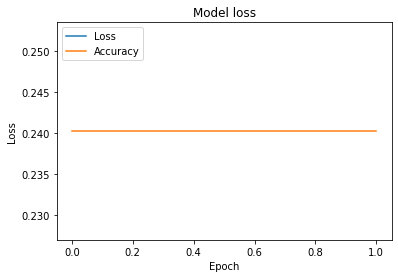

In [12]:
#Plot the loss and accuracy
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()



In [33]:
#Validate the model against the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

#Get the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


125/125 [==============================] - 0s 526us/step


0.687

In [34]:
#Weightwatcher
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
results = watcher.analyze()
results



,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,rf,sigma,spectral_norm,stable_rank,status,sv_max,warning,weak_rank_loss,xmax,xmin
0,0,dense_17,0.127666,41,100,2.439024,2.731544,2.494134,0.902517,True,...,1,0.408129,8.187500,9.406250,success,2.861328,,0,8.187500,1.628906
1,1,dense_18,0.090814,100,100,1.000000,2.662222,2.515332,0.897511,True,...,1,0.303479,8.804688,14.937500,success,2.966797,,0,8.804688,1.570312
2,2,dense_19,0.081140,100,100,1.000000,2.970568,2.929955,0.903572,True,...,1,0.430013,9.695312,13.507812,success,3.113281,,0,9.695312,2.119141
3,3,dense_20,0.080449,100,100,1.000000,3.165540,2.646194,0.908939,True,...,1,0.461695,6.851562,18.203125,success,2.617188,,0,6.851562,2.074219
4,5,dense_21,0.103152,23,100,4.347826,2.530884,2.792870,0.883906,True,...,1,0.395273,12.687500,4.035156,success,3.562500,,0,12.687500,1.244141
